In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 



In [3]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1 
    word_count = len(vocab.keys())
    return sent_count,word_count

In [14]:
clinical_text_df = pd.read_csv(r"C:\Users\B MAHESH BABU\Documents\clinical3.csv")

print(clinical_text_df.columns)
clinical_text_df.head(5)

Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords', 'Unnamed: 6', 'Unnamed: 7'],
      dtype='object')


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,Unnamed: 6,Unnamed: 7
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller...",NaN,NaN
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh...",NaN,NaN
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart...",NaN,NaN
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple...",NaN,NaN
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo...",NaN,NaN


In [30]:
print("Number of sentences in transcriptions column: "+ str(sent_count))
print("Number of unique words in transcriptions column: "+str(word_count))



data_categories  = clinical_text_df.groupby(clinical_text_df['medical_specialty'])
i = 1
print('===========Original Categories =======================')
for catName,dataCategory in data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1
print('==================================')

Number of sentences in transcriptions column: 139918
Number of unique words in transcriptions column: 35779
===========Original Categories =======================
Cat:1  Allergy / Immunology : 7
Cat:2  Autopsy : 8
Cat:3  Bariatrics : 18
Cat:4  Cardiovascular / Pulmonary : 371
Cat:5  Chiropractic : 14
Cat:6  Consult - History and Phy. : 515
Cat:7  Cosmetic / Plastic Surgery : 27
Cat:8  Dentistry : 27
Cat:9  Dermatology : 29
Cat:10  Diets and Nutritions : 10
Cat:11  Discharge Summary : 108
Cat:12  ENT - Otolaryngology : 96
Cat:13  Emergency Room Reports : 75
Cat:14  Endocrinology : 19
Cat:15  Gastroenterology : 224
Cat:16  General Medicine : 259
Cat:17  Hematology - Oncology : 90
Cat:18  Hospice - Palliative Care : 6
Cat:19  IME-QME-Work Comp etc. : 16
Cat:20  Lab Medicine - Pathology : 8
Cat:21  Letters : 23
Cat:22  Nephrology : 81
Cat:23  Neurology : 222
Cat:24  Neurosurgery : 93
Cat:25  Obstetrics / Gynecology : 155
Cat:26  Office Notes : 50
Cat:27  Ophthalmology : 83
Cat:28  Orthoped

In [31]:
filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 50)
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
i=1
print('============Reduced Categories ======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============ Reduced Categories ======================')

============Reduced Categories ======================
Cat:1  Cardiovascular / Pulmonary : 371
Cat:2  Consult - History and Phy. : 515
Cat:3  Discharge Summary : 108
Cat:4  ENT - Otolaryngology : 96
Cat:5  Emergency Room Reports : 75
Cat:6  Gastroenterology : 224
Cat:7  General Medicine : 259
Cat:8  Hematology - Oncology : 90
Cat:9  Nephrology : 81
Cat:10  Neurology : 222
Cat:11  Neurosurgery : 93
Cat:12  Obstetrics / Gynecology : 155
Cat:13  Ophthalmology : 83
Cat:14  Orthopedic : 354
Cat:15  Pain Management : 61
Cat:16  Pediatrics - Neonatal : 70
Cat:17  Psychiatry / Psychology : 53
Cat:18  Radiology : 273
Cat:19  SOAP / Chart / Progress Notes : 166
Cat:20  Surgery : 1086
Cat:21  Urology : 156
============ Reduced Categories ======================


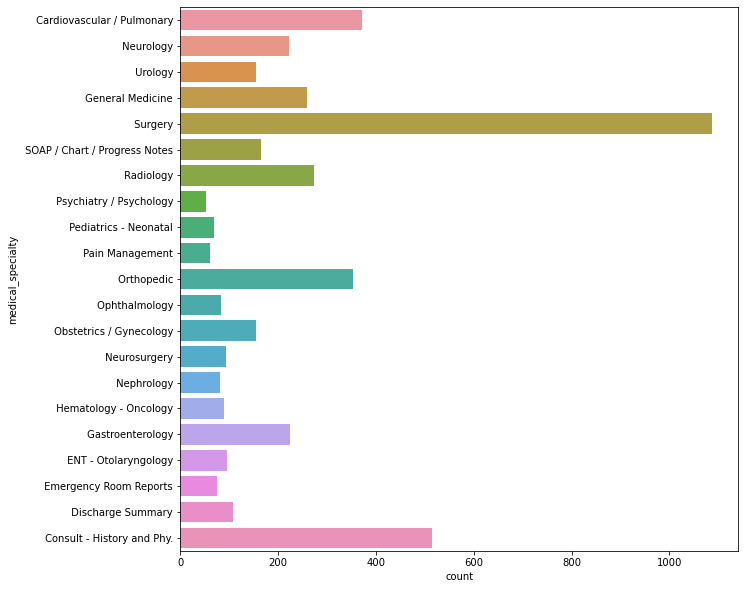

In [32]:
plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data = filtered_data_categories )
plt.show()

In [33]:
data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape


(4591, 2)

In [34]:
def clean_text(text ): 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()]) 
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    #BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    
    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text2 = BAD_SYMBOLS_RE.sub('', text2)
    return text2

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    
    intial_sentences= sentences[0:1]
    final_sentences = sentences[len(sentences)-2: len(sentences)-1]
    
    for sentence in intial_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))       
    return ' '.join(wordlist)

In [36]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names())
print(feature_names)

['000', '07', '08', '10', '10 mg', '100', '11', '12', '13', '14', '15', '15 blade', '16', '17', '18', '19', '20', '20 mg', '2007', '2008', '22', '24', '25', '30', '40', '50', '60', '70', '75', '80', '90', '92', '95', '98', 'abc', 'abcd', 'abdomen', 'abdomen soft', 'abdomen soft nontender', 'abdominal', 'abdominal pain', 'able', 'abnormal', 'abnormalities', 'achieved', 'active', 'activity', 'acute', 'acute distress', 'addition', 'additional', 'adequate', 'adhesions', 'administered', 'admission', 'admitted', 'advanced', 'age', 'ago', 'air', 'alcohol', 'alert', 'alert oriented', 'allergies', 'allergies known', 'anastomosis', 'anemia', 'anesthesia', 'anesthesia general', 'anesthesia general endotracheal', 'anesthetic', 'ankle', 'anterior', 'anteriorly', 'antibiotic', 'antibiotics', 'aorta', 'aortic', 'apparently', 'appear', 'appearance', 'appeared', 'appearing', 'appears', 'applied', 'applied patient', 'appropriate', 'approximately', 'approximately cm', 'area', 'areas', 'arm', 'artery', 'a

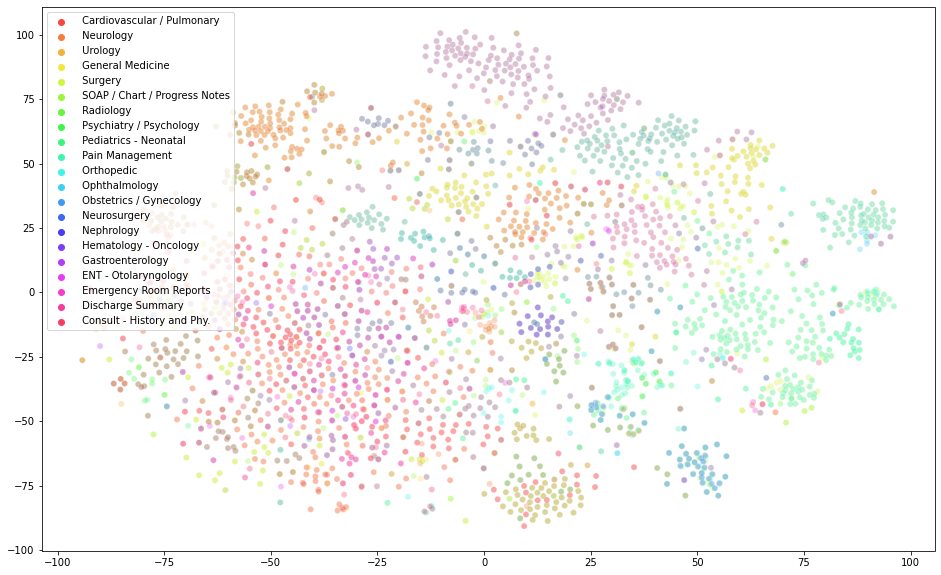

In [37]:
import gc
gc.collect()
tfIdfMatrix = tfIdfMat.todense()
labels = data['medical_specialty'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix)
plt.figure(figsize=(16,10))
palette = sns.hls_palette(21, l=.6, s=.9)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    palette= palette,
    legend="full",
    alpha=0.3
)
plt.show()

In [39]:
gc.collect()
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1) 

In [41]:
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(3443, 614)
Test_Set_Size:(1148, 614)


In [43]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

In [44]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels)

C:\Users\B MAHESH BABU\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[' Cardiovascular / Pulmonary' ' Neurology' ' Urology' ' General Medicine'
 ' Surgery' ' SOAP / Chart / Progress Notes' ' Radiology'
 ' Psychiatry / Psychology' ' Pediatrics - Neonatal' ' Pain Management'
 ' Orthopedic' ' Ophthalmology' ' Obstetrics / Gynecology' ' Neurosurgery'
 ' Nephrology' ' Hematology - Oncology' ' Gastroenterology'
 ' ENT - Otolaryngology' ' Emergency Room Reports' ' Discharge Summary'
 ' Consult - History and Phy.'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


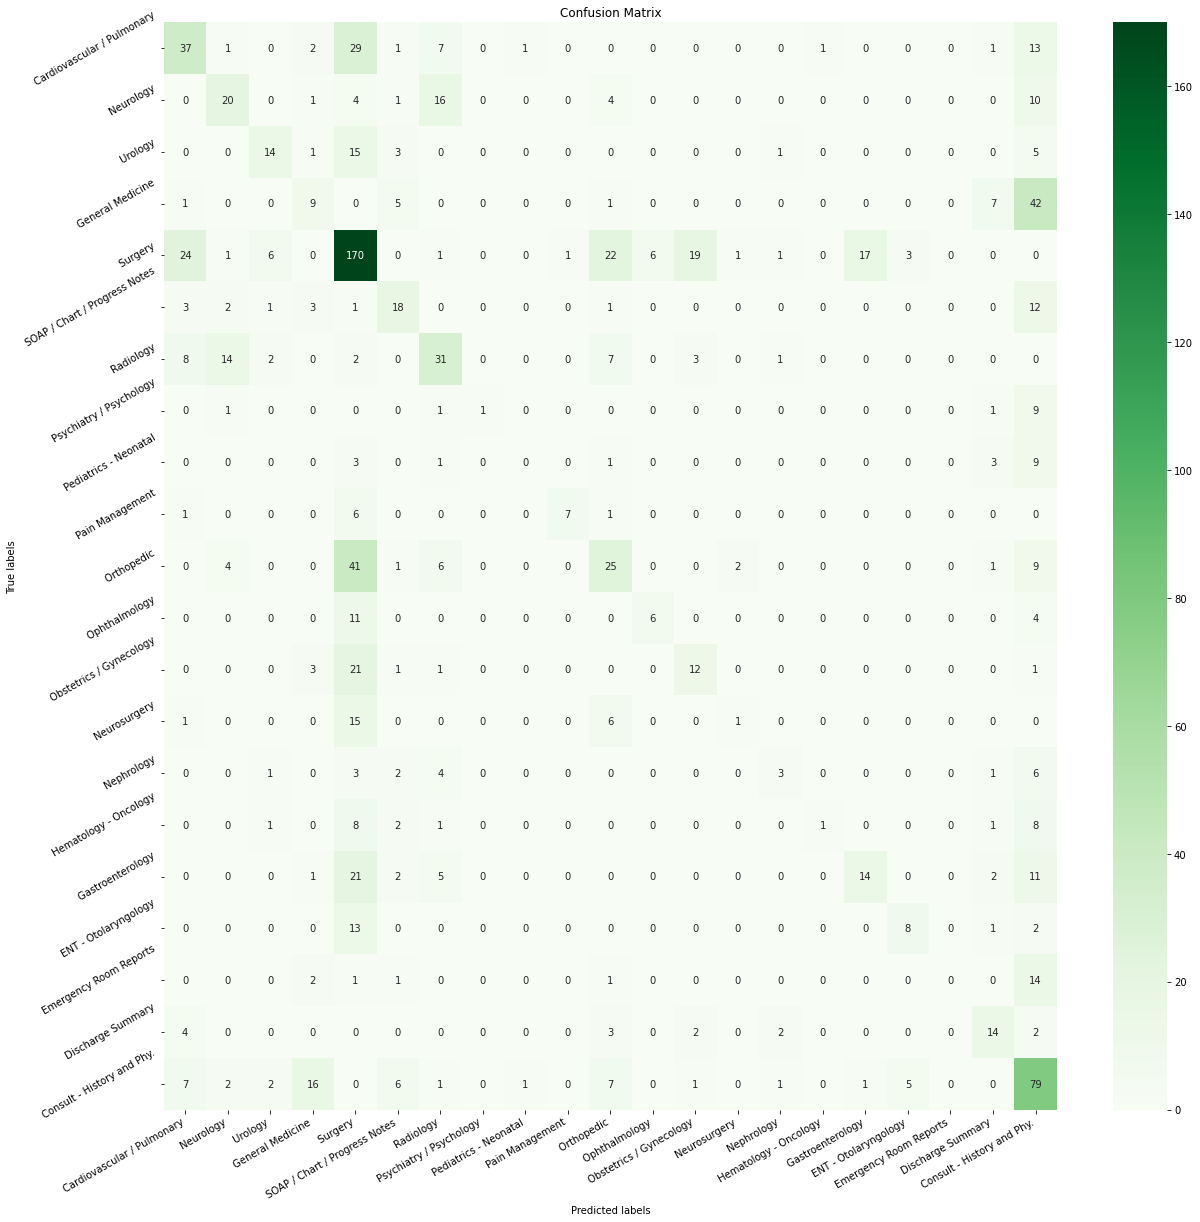

In [45]:
fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()


In [46]:
print(classification_report(y_test,y_test_pred,labels=category_list))


                                precision    recall  f1-score   support

    Cardiovascular / Pulmonary       0.43      0.40      0.41        93
                     Neurology       0.44      0.36      0.40        56
                       Urology       0.52      0.36      0.42        39
              General Medicine       0.24      0.14      0.17        65
                       Surgery       0.47      0.62      0.53       272
 SOAP / Chart / Progress Notes       0.42      0.44      0.43        41
                     Radiology       0.41      0.46      0.43        68
       Psychiatry / Psychology       1.00      0.08      0.14        13
         Pediatrics - Neonatal       0.00      0.00      0.00        17
               Pain Management       0.88      0.47      0.61        15
                    Orthopedic       0.32      0.28      0.30        89
                 Ophthalmology       0.50      0.29      0.36        21
       Obstetrics / Gynecology       0.32      0.31      0.32  

C:\Users\B MAHESH BABU\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\B MAHESH BABU\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\B MAHESH BABU\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75,min_df=5, use_idf=True, smooth_idf=True,sublinear_tf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names())
print(feature_names)

['000', '07', '08', '10', '10 mg', '100', '11', '12', '13', '14', '15', '15 blade', '16', '17', '18', '19', '20', '20 mg', '2007', '2008', '22', '24', '25', '30', '40', '50', '60', '70', '75', '80', '90', '92', '95', '98', 'abc', 'abcd', 'abdomen', 'abdomen soft', 'abdomen soft nontender', 'abdominal', 'abdominal pain', 'able', 'abnormal', 'abnormalities', 'achieved', 'active', 'activity', 'acute', 'acute distress', 'addition', 'additional', 'adequate', 'adhesions', 'administered', 'admission', 'admitted', 'advanced', 'age', 'ago', 'air', 'alcohol', 'alert', 'alert oriented', 'allergies', 'allergies known', 'anastomosis', 'anemia', 'anesthesia', 'anesthesia general', 'anesthesia general endotracheal', 'anesthetic', 'ankle', 'anterior', 'anteriorly', 'antibiotic', 'antibiotics', 'aorta', 'aortic', 'apparently', 'appear', 'appearance', 'appeared', 'appearing', 'appears', 'applied', 'applied patient', 'appropriate', 'approximately', 'approximately cm', 'area', 'areas', 'arm', 'artery', 'a

C:\Users\B MAHESH BABU\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[' Cardiovascular / Pulmonary' ' Neurology' ' Urology' ' General Medicine'
 ' Surgery' ' SOAP / Chart / Progress Notes' ' Radiology'
 ' Psychiatry / Psychology' ' Pediatrics - Neonatal' ' Pain Management'
 ' Orthopedic' ' Ophthalmology' ' Obstetrics / Gynecology' ' Neurosurgery'
 ' Nephrology' ' Hematology - Oncology' ' Gastroenterology'
 ' ENT - Otolaryngology' ' Emergency Room Reports' ' Discharge Summary'
 ' Consult - History and Phy.'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


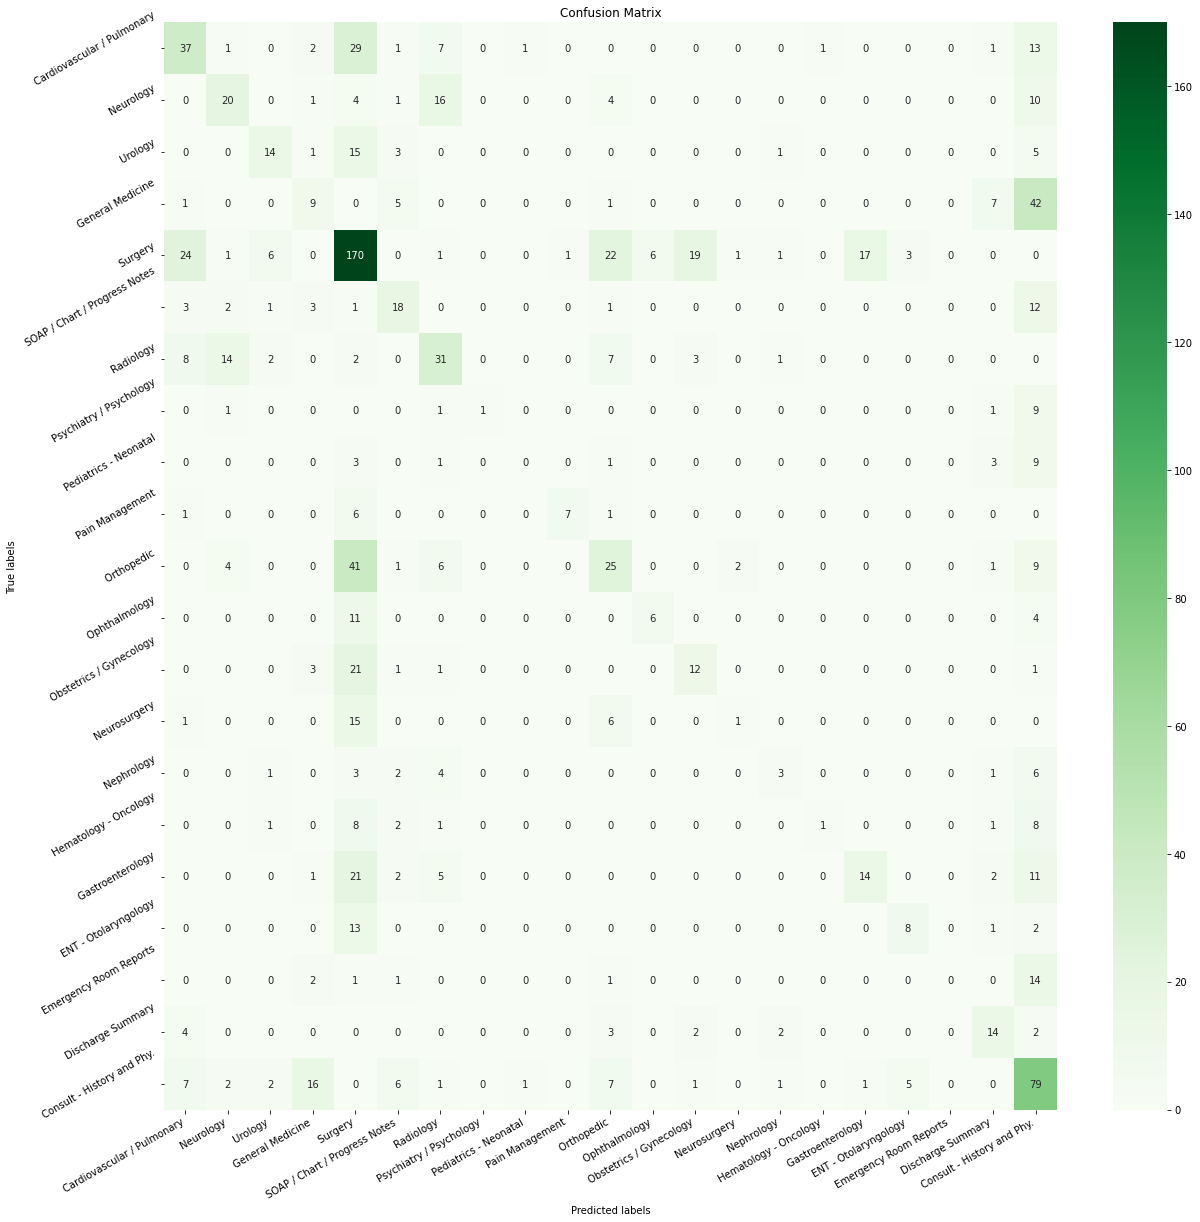

                                precision    recall  f1-score   support

    Cardiovascular / Pulmonary       0.43      0.40      0.41        93
                     Neurology       0.44      0.36      0.40        56
                       Urology       0.52      0.36      0.42        39
              General Medicine       0.24      0.14      0.17        65
                       Surgery       0.47      0.62      0.53       272
 SOAP / Chart / Progress Notes       0.42      0.44      0.43        41
                     Radiology       0.41      0.46      0.43        68
       Psychiatry / Psychology       1.00      0.08      0.14        13
         Pediatrics - Neonatal       0.00      0.00      0.00        17
               Pain Management       0.88      0.47      0.61        15
                    Orthopedic       0.32      0.28      0.30        89
                 Ophthalmology       0.50      0.29      0.36        21
       Obstetrics / Gynecology       0.32      0.31      0.32  

C:\Users\B MAHESH BABU\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\B MAHESH BABU\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\B MAHESH BABU\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))